# Global and Regional RHALE

This tutorial is an introduction to global and regional RHALE; it demonstrates how to use `Effector` to explain a black box function, utilizing two synthetic datasets—one with uncorrelated features and the other with correlated features.

In [17]:
import numpy as np
import effector

## Simulation example

### Data Generating Distribution

We will generate $N=1000$ examples with $D=3$ features. In the uncorrelated setting, all variables are uniformly distributed, i.e., $x_i \sim \mathcal{U}(-1,1)$. In the correlated setting, we keep the distributional assumptions for $x_1$ and $x_2$ but define $x_3$ such that it is identical to $x_3$ by: $x_3 = x_1$.

In [18]:
def generate_dataset_uncorrelated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = np.random.uniform(-1, 1, size=N)
    return np.stack((x1, x2, x3), axis=-1)

def generate_dataset_correlated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = x1
    return np.stack((x1, x2, x3), axis=-1)

# generate the dataset for the uncorrelated and correlated setting
N = 10_000
X_uncor = generate_dataset_uncorrelated(N)
X_cor = generate_dataset_correlated(N)

### Black-box function

We will use the following linear model with a subgroup-specific interaction term:
 $$ y = 3x_1I_{x_3>0} - 3x_1I_{x_3\leq0} + x_3$$.

## Ground truth effect (uncorrelated setting)

In the uncorrelated scenario, the effects are as follows:

- For the feature $x_1$, the global effect will be $3x_1$ half of the time (when $I_{x_3>0}$) and $-3x_1$ the other half (when $3x_1I_{x_3\leq0}$). This results in a zero global effect with high heterogeneity. The regional effect should be divided into two subregions: $x_3>0$ and $x_3 \leq 0$, leading to two regional effects with zero heterogeneity: $3x_1$ and $-3x_1$.

- For feature $x_2$, the global effect is zero, without heterogeneity.

- For feature $x_3$, there is a global effect of $x_3$ without heterogeneity due to the last term. Depending on the feature effect method, the terms $3x_1I_{x_3>0}$ and $-3x_1I_{x_3\leq0}$ may also introduce some effect.

## Ground truth effect (correlated setting)

In the correlated scenario, where $x_3 = x_1$, the effects are as follows:

- For the feature $x_1$, the global effect is $3x_1I_{x_1>0} - 3x_1I_{x_1\leq 0}$ without heterogeneity. This is because when $x_1>0$, $x_3>0$, so only the term $3x_1$ is active. Similarly, when $x_1\leq 0$, $x_3 \leq 0$, making the term $-3x_1$ active.
- For the feature $x_2$, the global effect is zero, without heterogeneity.
- For the feature $x_3$, the global effect is $x_3$.

In [19]:
def model(x):
    f = np.where(x[:,2] > 0, 3*x[:,0] + x[:,2], -3*x[:,0] + x[:,2])
    return f

def model_jac(x):
    dy_dx = np.zeros_like(x)
    
    ind1 = x[:, 2] > 0
    ind2 = x[:, 2] <= 0
    
    dy_dx[ind1, 0] = 3
    dy_dx[ind2, 0] = -3
    dy_dx[:, 2] = 1
    return dy_dx


In [20]:
Y_cor = model(X_cor)
Y_uncor = model(X_uncor)      

## (RH)ALE

ALE defines the feature effect as **the integral of the partial derivative of the model's output with respect to the feature of interest**:

$$\text{ALE}(x_s) = \int_{z=0}^{x_s} \mathbb{E}_{x_c|x_s=z}\left [ \frac{\partial f}{\partial x_s} (z, x_c) \right ] \partial z$$

The approximation is defined as:

$$\hat{\text{ALE}}(x_s) = \sum_{k=1}^{k_{x_s}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [ f(z_k, x_c) - f(z_{k-1}, x_c) \right ]$$

$\hat{\text{ALE}}(x_s)$ uses a Riemannian sum to approximate the integral of $\text{ALE}(x_s)$. The axis of the $s$-th feature is split in $K$ bins (intervals) of equal size. In each bin, the average effect of the feature of interest is estimated using the instances that fall in the bin. The average effect in each bin is called bin-effect. 

Robust and Heterogeneity-aware ALE (RHALE) is a variant of ALE, proposed by [Gkolemis et. al](https://arxiv.org/abs/2309.11193), where the local effects are computed using automatic differentiation and the bin-splitting is automated:

$$\hat{\text{RHALE}}(x_s) = \sum_{k=1}^{k_{x_s}} \frac{1}{ \left | \mathcal{S}_k \right |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \frac{\partial f}{\partial x_s} (x_s^{(i)}, x_c^{(i)})$$

 In their paper, [Gkolemis et. al](https://arxiv.org/abs/2309.11193) showed that RHALE has specific advantages over ALE: (a) it ensures on-distribution sampling (b) an unbiased estimation of the heterogeneity and (c) an optimal trade-off between bias and variance. In our example, we will use the RHALE approximation.

## Uncorrelated setting

### Global RHALE

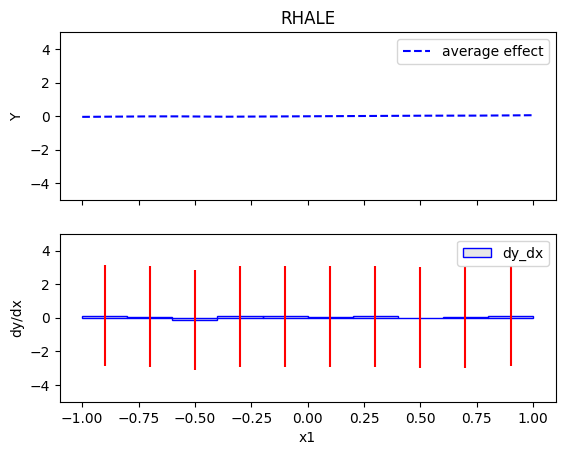

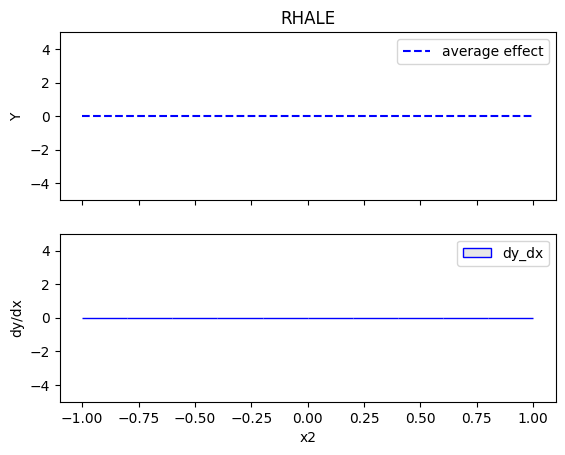

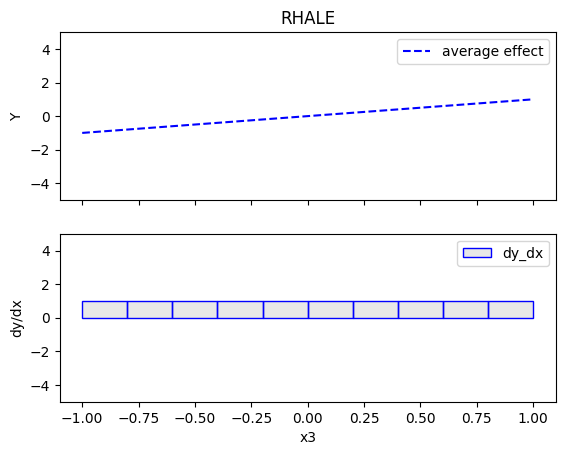

In [21]:
rhale = effector.RHALE(data=X_uncor, model=model, model_jac=model_jac, feature_names=['x1','x2','x3'], target_name="Y")

binning_method = effector.axis_partitioning.Fixed(10, min_points_per_bin=0)
rhale.fit(features="all", binning_method=binning_method, centering=True)

rhale.plot(feature=0, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=1, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=2, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])

### Conclusion

* the global effect of $x_1$ is $0$ with some heterogeneity as shown by the red bars. The type of the heterogeneity is not further analyzed
* the global effect of $x_2$ is $0$ without heterogeneity
* the global effect of $x_3$ is $x_3$ without heterogeneity. This is due to the way RHALE formulates the global effect; **integral of the partial derivative of the model's output with respect to the feature of interest**. Therefore, it cannot capture the discontinuity at $x_3=0$.

### Regional RHALE

The disadvantage of RHALE plot is that it does not reveal the type of heterogeneity. Therefore, Regional (RH)ALE plots are very helpful to identify the type of heterogeneity. Let's see that in practice:

In [22]:
regional_rhale = effector.RegionalRHALE(
    data=X_uncor, 
    model=model, 
    model_jac= model_jac, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

binning_method = effector.axis_partitioning.Fixed(11, min_points_per_bin=0)

space_partitioner = effector.partitioning.Regions(heter_pcg_drop_thres=0.6, nof_candidate_splits_for_numerical=11)
regional_rhale.fit(
    features="all",
    space_partitioner=space_partitioner,
    binning_method=binning_method,
)


100%|██████████| 3/3 [00:00<00:00,  5.79it/s]


In [23]:
regional_rhale.summary(features=0)



Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 8.99 || nof_instances: 10000 || weight: 1.00
        Node id: 1, name: x1 | x3 <= -0.09, heter: 0.00 || nof_instances: 10000 || weight: 1.00
        Node id: 2, name: x1 | x3  > -0.09, heter: 2.62 || nof_instances: 10000 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 8.99
        Level 1, heter: 2.62 || heter drop : 6.38 (units), 70.92% (pcg)




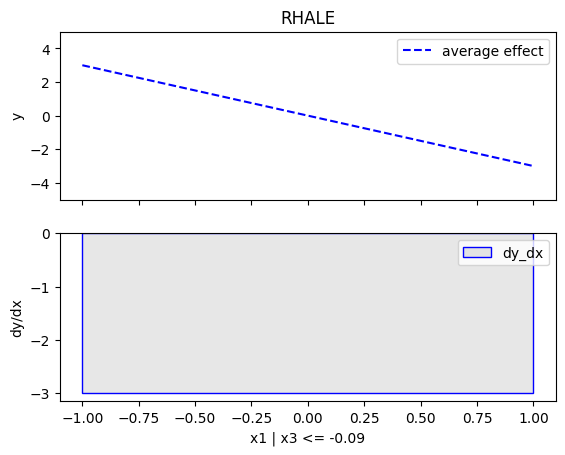

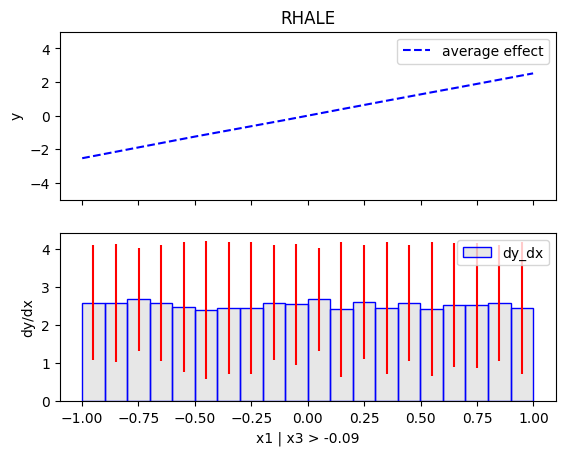

In [24]:
regional_rhale.plot(feature=0, node_idx=1, heterogeneity="std", centering=True, y_limits=[-5, 5])
regional_rhale.plot(feature=0, node_idx=2, heterogeneity="std", centering=True, y_limits=[-5, 5])

In [25]:
regional_rhale.summary(features=1)



Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.00 || nof_instances: 10000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.00




In [26]:
regional_rhale.summary(features=2)



Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 0.00 || nof_instances: 10000 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 0.00




### Conclusion

* For $x_1$, the algorithm finds two regions, one for $x_3 \leq 0$ and one for $x_3 > 0$
  * when $x_3>0$ the effect is $3x_1$ without heterogeneity
  * when $x_3 \leq 0$, the effect is $-3x_1$ without heterogeneity
* For $x_2$ the algorithm does not find any subregion 
* For $x_3$, the algorithm does not find any subregion

## Correlated setting

### Global RHALE

In [27]:
rhale = effector.RHALE(data=X_cor, model=model, model_jac=model_jac, 
                       feature_names=['x1','x2','x3'], 
                       target_name="Y", 
                       axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T)
binning_method = effector.axis_partitioning.Fixed(10, min_points_per_bin=0)
rhale.fit(features="all", binning_method=binning_method, centering=True)

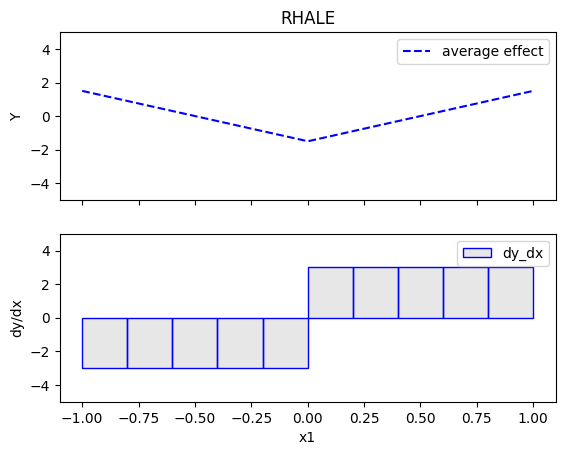

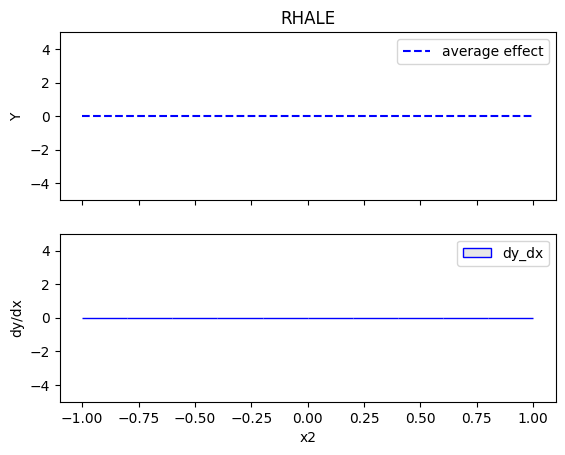

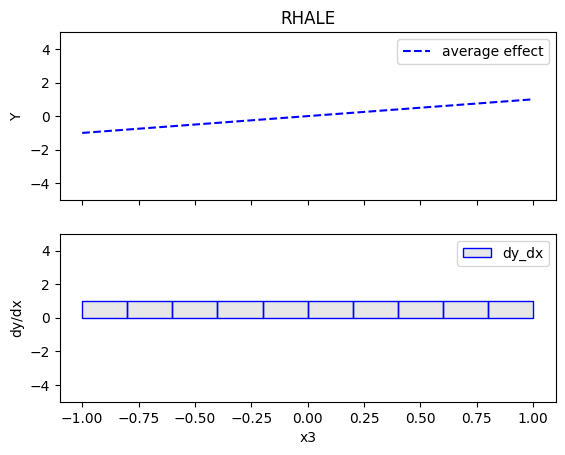

In [28]:
rhale.plot(feature=0, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=1, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=2, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])

### Conclusion

* For $x_1$, RHALE effect matches with the ground truth; the global effect is $3x_1I_{x_1>0} - 3x_1I_{x_1\leq 0}$ without heterogeneity. This is because when $x_1>0$, $x_3>0$, so only the term $3x_1$ is active. Similarly, when $x_1\leq 0$, $x_3 \leq 0$, making the term $-3x_1$ active.
* For $x_2$ the effect is zero without heterogeneity.
* For $x_3$, the effect is $x_3$ without heterogeneity. This happens for the same reasons as in the uncorrelated case; RHALE formulates the global effect as an **integral of the partial derivative of the model's output with respect to the feature of interest**. Therefore, it cannot capture the discontinuity at $x_3=0$.

### Regional RHALE

In [29]:
regional_rhale = effector.RegionalRHALE(
    data=X_cor, 
    model=model, 
    model_jac= model_jac, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

binning_method = effector.axis_partitioning.Fixed(10, min_points_per_bin=0)
space_partitioner = effector.partitioning.Regions(heter_pcg_drop_thres=0.6, nof_candidate_splits_for_numerical=11)
regional_rhale.fit(
    features="all",
    space_partitioner=space_partitioner,
    binning_method=binning_method,
)


100%|██████████| 3/3 [00:00<00:00,  6.02it/s]


In [30]:
regional_rhale.summary(features=0)



Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 0.00 || nof_instances: 10000 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 0.00




In [31]:
regional_rhale.summary(features=1)



Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.00 || nof_instances: 10000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.00




In [32]:
regional_rhale.summary(features=2)



Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 0.00 || nof_instances: 10000 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 0.00




### Conclusion

* For $x_1$, the algorithm does not find any subregion 
* For $x_2$ the algorithm does not find any subregion 
* For $x_3$, the algorithm does not find any subregion 